In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as np
import jax.random as jr
import jax.scipy.special as spsp
from jax import value_and_grad, vmap

import matplotlib.pyplot as plt

from ssm.factorial_hmm.posterior import _factorial_hmm_log_normalizer
from ssm.hmm.posterior import hmm_log_normalizer

# Try constructing a factorial HMM

In [3]:
from ssm.factorial_hmm.models import NormalFactorialHMM

num_states = (2, 2, 2)
factorial_hmm = NormalFactorialHMM(num_states=num_states, seed=jr.PRNGKey(0))

(0.0, 200.0)

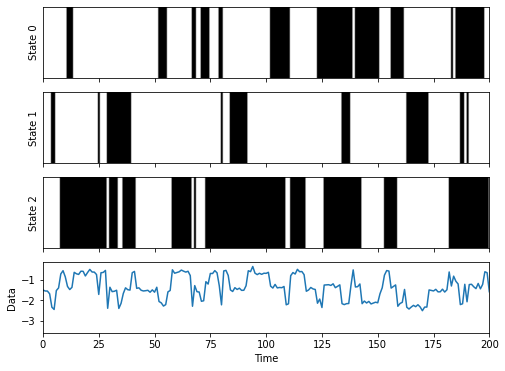

In [4]:
states, data = factorial_hmm.sample(jr.PRNGKey(0), 10000)

# Plot the states and data
fig, axs = plt.subplots(len(num_states) + 1, 1, figsize=(8, 6), sharex=True)
for i in range(len(num_states)):
    axs[i].imshow(states[i][None, :], cmap="Greys", aspect="auto")
    axs[i].set_ylabel("State {}".format(i))
    axs[i].set_yticks([])
axs[-1].plot(data)
axs[-1].set_ylabel("Data")
axs[-1].set_xlabel("Time")
axs[-1].set_xlim(0, 200)

# Construct another factorial HMM and try to fit it

In [5]:
test_factorial_hmm = NormalFactorialHMM(num_states, seed=jr.PRNGKey(1))
lps, _, posteriors = test_factorial_hmm.fit(data, tol=-1)

Initializing...
Done.


[jit compiling...]:   0%|          | 0/100 [00:00<?, ?it/s]

jitting


LP: -21759.117:   1%|          | 1/100 [00:03<06:30,  3.94s/it]

jitting


LP: -5229.335: 100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Text(0, 0.5, 'log probability')

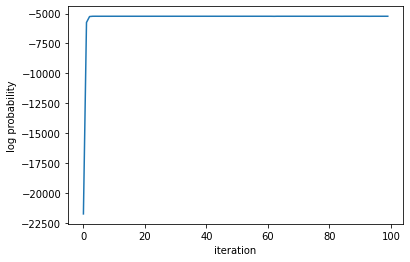

In [11]:
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

(0.0, 200.0)

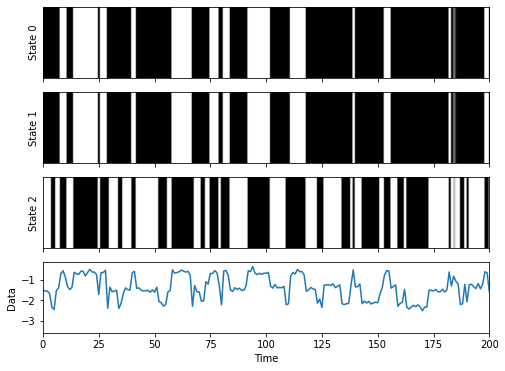

In [9]:
# compute marginal probabilities for each state
expected_states = posteriors.expected_states[0]
marginals = []
for j in range(len(num_states)):
    axes = tuple(np.concatenate([np.arange(j), np.arange(j+1, len(num_states))]) + 1)
    marginals.append(np.sum(expected_states, axis=axes))

# Plot the states and data
fig, axs = plt.subplots(len(num_states) + 1, 1, figsize=(8, 6), sharex=True)
for i in range(len(num_states)):
    axs[i].imshow(marginals[i][None, :, 1], cmap="Greys", aspect="auto", vmin=0, vmax=1)
    axs[i].set_ylabel("State {}".format(i))
    axs[i].set_yticks([])
    
axs[-1].plot(data)
axs[-1].set_ylabel("Data")
axs[-1].set_xlabel("Time")
axs[-1].set_xlim(0, 200)



In [14]:
factorial_hmm._emissions._distribution.loc

DeviceArray([[[-1.5112934 , -0.63249874],
              [-2.3792994 , -1.5005047 ]],

             [[-2.1733613 , -1.2945665 ],
              [-3.041367  , -2.1625724 ]]], dtype=float32)

In [13]:
test_factorial_hmm._emissions._distribution.loc

DeviceArray([[[-0.29943854, -0.7436352 ],
              [-3.2376444 , -3.681841  ]],

             [[ 1.3292058 ,  0.88500917],
              [-1.609     , -2.0531967 ]]], dtype=float32)

# Scratch

In [ ]:
rng = jr.PRNGKey(0)
num_states = (3, 4)
num_timesteps = 10

log_initial_state_probs = np.zeros(num_states)
log_transition_matrices = tuple(
    jr.normal(key, (k, k)) for key, k in zip(jr.split(rng, len(num_states)), num_states))
log_transition_matrices = tuple(
    x - spsp.logsumexp(x, axis=1, keepdims=True)
    for x in log_transition_matrices
)

rng, this_rng = jr.split(rng, 2)
log_likelihoods = jr.normal(this_rng, (num_timesteps,) + num_states)

In [ ]:
log_normalizer, filtered_potentials = \
    _factorial_hmm_log_normalizer(log_initial_state_probs,
                                  log_transition_matrices,
                                  log_likelihoods)



In [ ]:
big_transition_matrix = np.kron(
    np.exp(log_transition_matrices[0]),
    np.exp(log_transition_matrices[1]),
)


In [ ]:
log_normalizer2, filtered_potentials2 = \
    hmm_log_normalizer(log_initial_state_probs.reshape(-1),
                       np.log(big_transition_matrix),
                       log_likelihoods.reshape(num_timesteps, -1))


In [ ]:
log_normalizer, log_normalizer2

In [ ]:
np.allclose(filtered_potentials.reshape(num_timesteps, -1), filtered_potentials2)

# Test the gradient

In [ ]:
# _factorial_hmm_log_normalizer(log_initial_state_probs,
#                                   log_transition_matrices,
#                                   log_likelihoods)

f = value_and_grad(_factorial_hmm_log_normalizer, argnums=(1, 2), has_aux=True)
(log_normalizer, filtered_potentials), (expected_transitions, expected_states) = \
    f(log_initial_state_probs, log_transition_matrices, log_likelihoods)

# Joint distribution for the transitions

In [ ]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

In [ ]:
# In TFP, we can write this as:
prev_states = tuple(1 for _ in num_states)

Root = tfd.JointDistributionCoroutine.Root  # Convenient alias.
def model():
    for prev_state, log_transition_matrix in zip(prev_states, log_transition_matrices):
        yield Root(tfd.Categorical(logits=log_transition_matrix[prev_state]))
        
joint = tfd.JointDistributionCoroutine(model)
next_states = tuple(joint.sample(seed=jr.PRNGKey(1), sample_shape=(100,)))
joint.log_prob(next_states)
# next_states

In [ ]:
means = np.arange(12).astype(np.float32).reshape(num_states)
scales = np.ones(num_states)

dist = tfd.Normal(means, scales)

state = (0, 0)

dist[state].mean()

In [ ]:
data = jr.normal(jr.PRNGKey(0), (100,))
lps = vmap(dist.log_prob)(data)
lps.shape

In [ ]:
%debug